In [ ]:
# ===================================================================
# 共通セットアップセル (ローカル / Colab 共通)
# ===================================================================
import sys
import os
from pathlib import Path

# --- 1. 環境判別 ---
IN_COLAB = False
try:
    # Colab環境でのみインポートが成功する
    from google.colab import drive
    IN_COLAB = True
except ImportError:
    pass # ローカル環境


if IN_COLAB:
    # ==================================
    # Colab 環境でのセットアップ
    # ==================================
    print("環境: Colab を検出。セットアップを開始します。")

    # 1. Google Driveのマウント
    drive.mount('/content/drive')

    # 2. GitHubリポジトリのクローンまたはプル
    repo_path = Path('/content/braidyn-bc')
    if repo_path.exists():
        print("リポジトリを pull します...")
        os.chdir(repo_path)
        !git pull
    else:
        print("リポジトリを clone します...")
        !git clone https://github.com/nyaamikeneko/braidyn-bc.git
        os.chdir(repo_path)

    # 3. 依存ライブラリのインストール
    print("依存ライブラリをインストールします...")
    !pip install -q pynwb git+https://github.com/BraiDyn-BC/bdbc-nwb-explorer.git

    # 4. sys.path の設定
    project_root = repo_path
    if str(project_root) not in sys.path:
        sys.path.append(str(project_root))

    print(f"セットアップ完了。プロジェクトルート: {project_root}")

else:
    # ==================================
    # ローカル (VSCode) 環境でのセットアップ
    # ==================================
    print("環境: ローカル (VSCode) を検出。")

    # 1. sys.path の設定
    current_dir = Path.cwd()
    if current_dir.name == 'notebooks':
        # ノートブックが notebooks/ から実行された場合
        project_root = current_dir.parent
    else:
        # プロジェクトルート (braidyn-bc/) から実行されたと仮定
        project_root = current_dir

    if str(project_root) not in sys.path:
        sys.path.append(str(project_root))

    print(f"プロジェクトルート: {project_root}")

# ===================================================================
# 共通インポート・処理
# (セットアップが完了したため、config.py や src/ が読み込める)
# ===================================================================
print("\n共通モジュールをインポートします...")

import bdbc_nwb_explorer as nwbx
import src.data_loader as dl
import config  # config.py もここで読み込める

print(f"データパス (DATA_NWB_ROOT): {config.DATA_NWB_ROOT}")

In [ ]:
# --- 必要なデータを関数で読み出す ---
SESSION_ID = "VG1GC-105"
NWB_FILENAME = "VG1GC-105_2024-02-02_task-day8.nwb"
TASK_DAY_DIR = "task-day8"

# NWBデータの読み込み
# (dl は共通セルでインポート済み)
session = dl.load_nwb_session(SESSION_ID, NWB_FILENAME)

# CSVデータの読み込み
trials = dl.load_trials_csv(SESSION_ID, TASK_DAY_DIR)

# これ以降、 session や trials を使った分析処理を記述...
if trials is not None:
    print(trials.head())

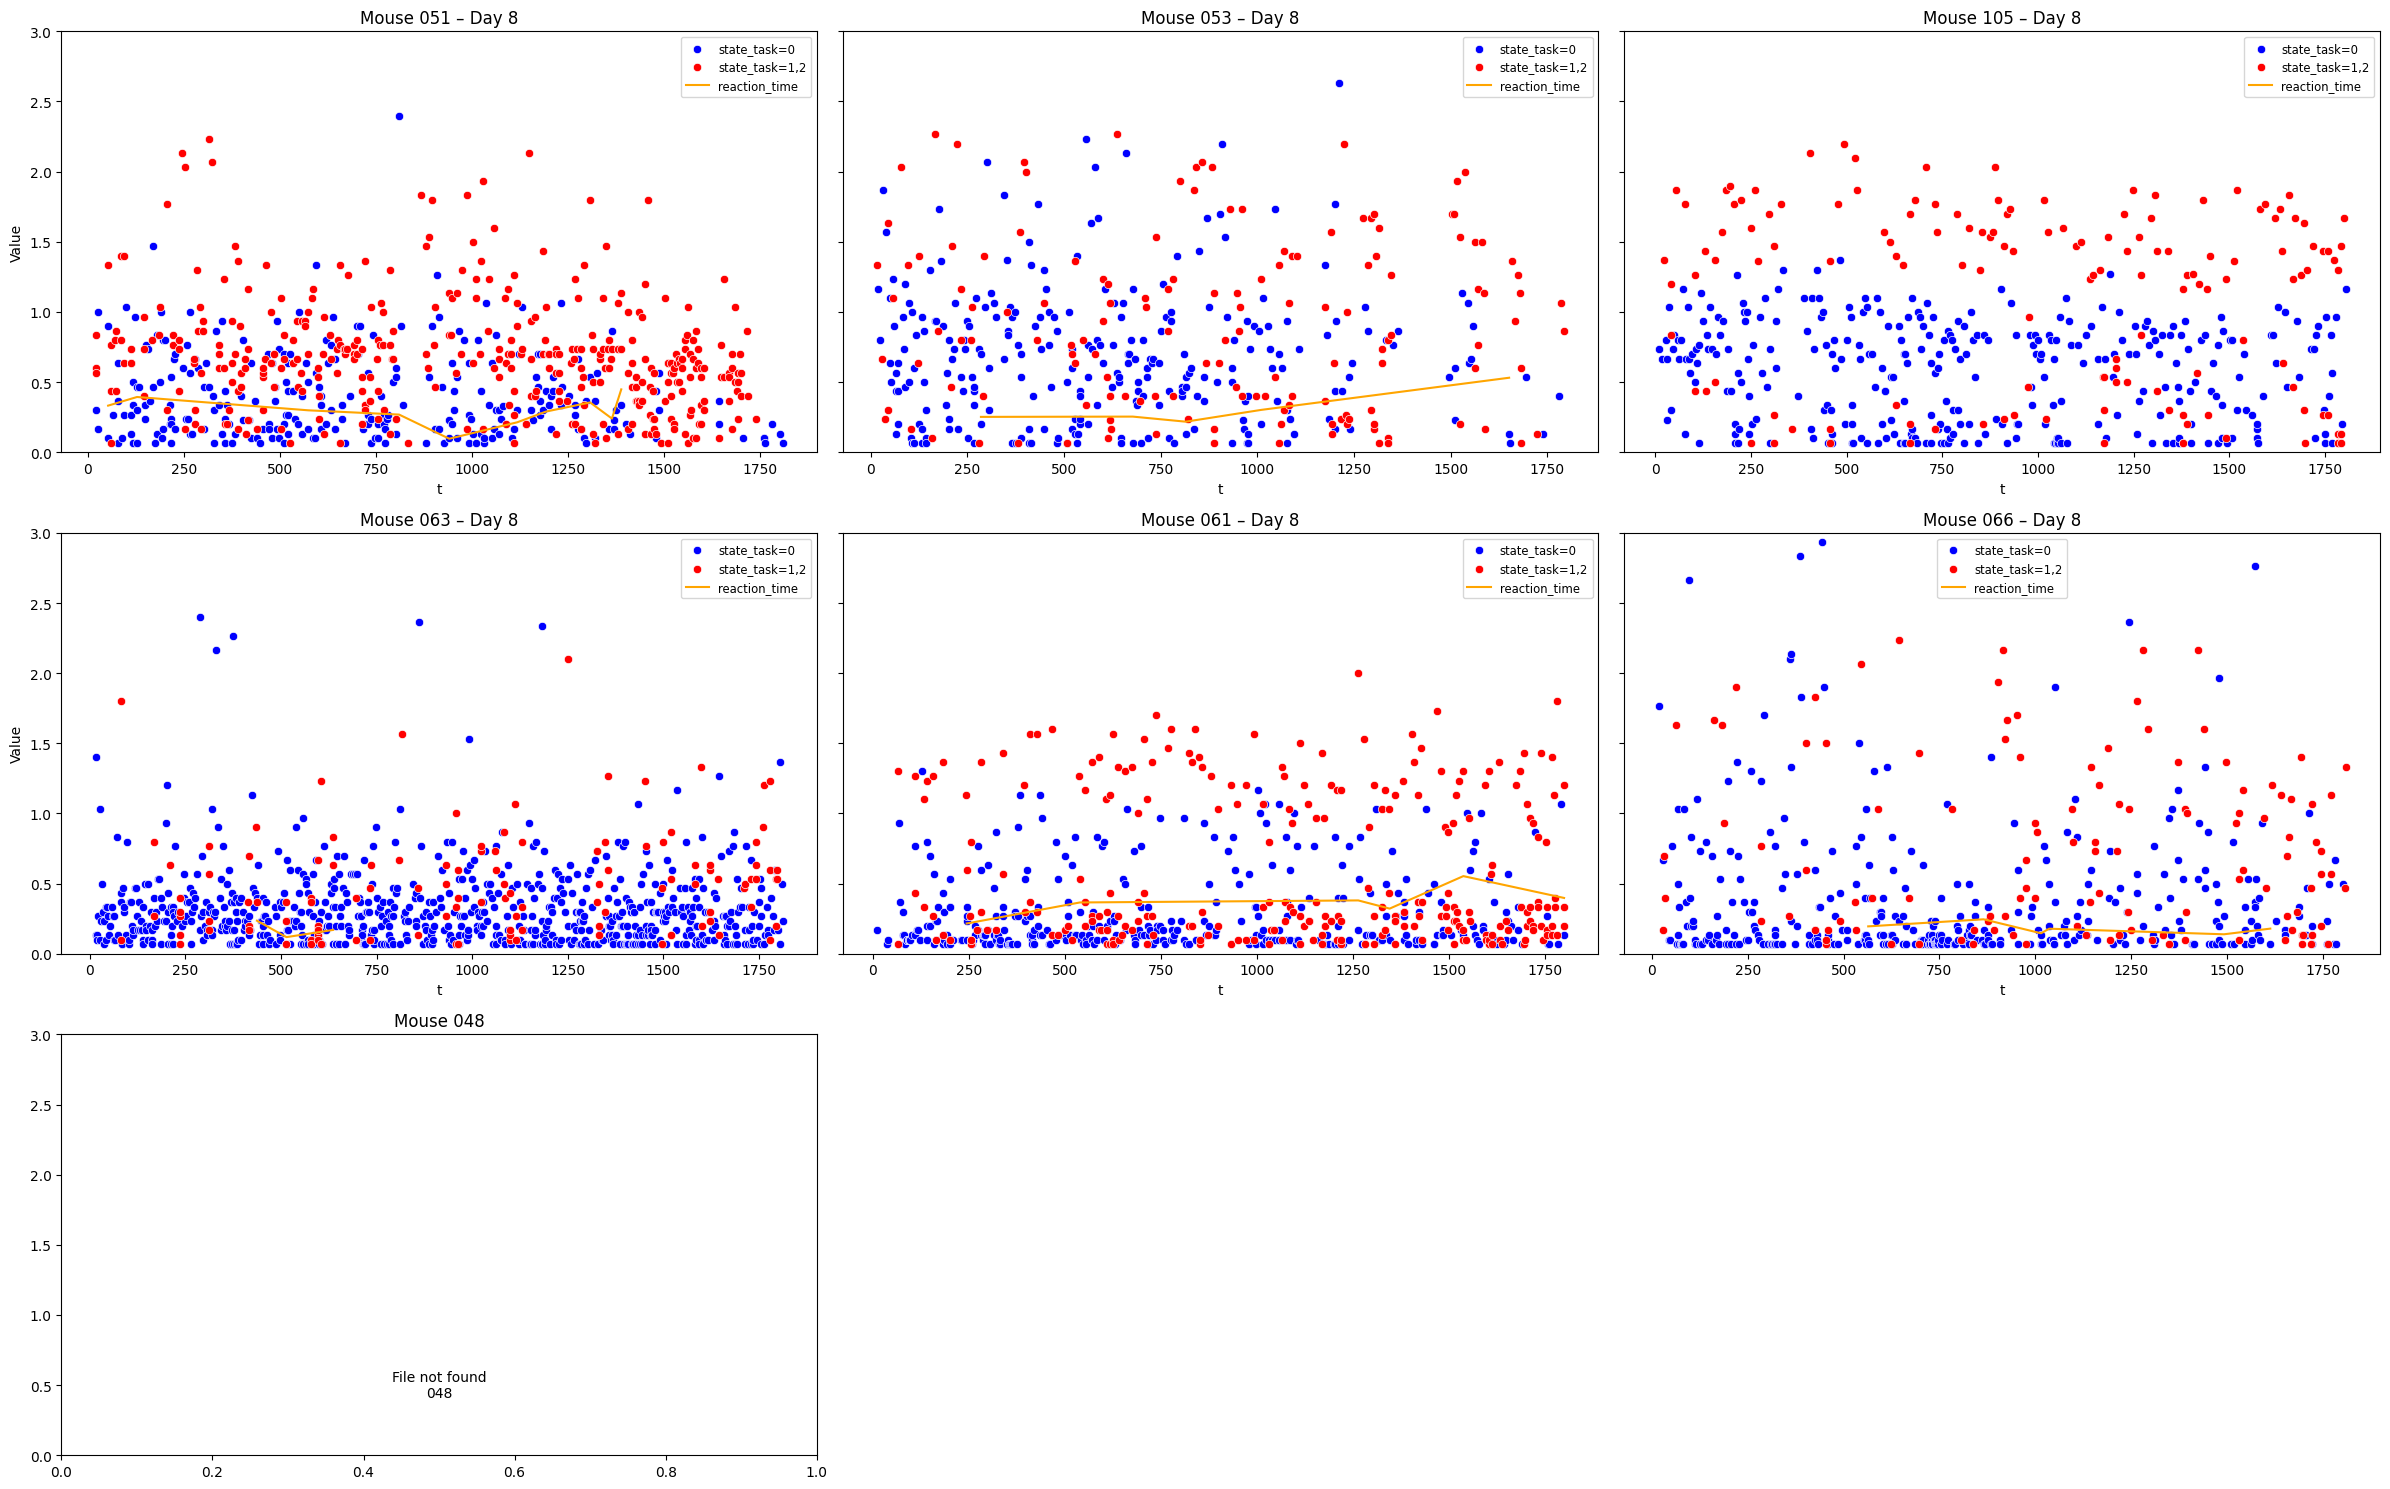

In [ ]:
#クラスタAのDAY８のレバー引き時間を可視化。pull?durationも消えてるし、reaction_timeの点もなくなっている

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, math

# 対象個体とパスのひな形
subjects = ["051", "053", "105", "063", "061", "066", "048"]
path_tpl  = "/content/drive/MyDrive/hackathon_data/VG1GC-{}/task-day8/trials_L1L2.csv"

# プロット設定
th_low, th_high = 0.04, 3.0       # diff_value の範囲
y_min, y_max    = 0, 3            # y 軸共通スケール
n_cols          = 3               # 列数（好みで変更可）
n_rows          = math.ceil(len(subjects) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols,
                         figsize=(8 * n_cols, 5 * n_rows),
                         sharey=True)
axes = axes.flatten()

for i, sid in enumerate(subjects):
    ax = axes[i]

    # 先頭ゼロあり／なしの両方を試す
    candidate_paths = [
        path_tpl.format(sid.lstrip("0")),   # 例: 051 → 51
        path_tpl.format(sid)                # 例: 051
    ]
    file_path = next((p for p in candidate_paths if os.path.exists(p)), None)

    if file_path is None:
        ax.text(0.5, 0.5, f"File not found\n{sid}", ha="center", va="center")
        ax.set_title(f"Mouse {sid}")
        continue

    df = pd.read_csv(file_path)

    # 条件フィルタ
    mask = (df["diff_value"] > th_low) & (df["diff_value"] < th_high)
    df = df[mask]

    # state_task 別に描画
    df0  = df[df["state_task"] == 0]
    df12 = df[df["state_task"].isin([1, 2])]

    sns.scatterplot(data=df0,  x="t", y="diff_value",
                    color="blue",  label="state_task=0",  ax=ax)
    sns.scatterplot(data=df12, x="t", y="diff_value",
                    color="red",   label="state_task=1,2", ax=ax)

    # reaction_time がある場合
    if "reaction_time" in df.columns:
        sns.lineplot(data=df, x="t", y="reaction_time",
                     color="orange", label="reaction_time", ax=ax)

    ax.set_title(f"Mouse {sid} – Day 8")
    ax.set_xlabel("t")
    ax.set_ylabel("Value")
    ax.set_ylim(y_min, y_max)
    ax.legend(fontsize="small")

# 余った sub-axes を消す（7匹→9枠中2枠空き）
for j in range(len(subjects), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


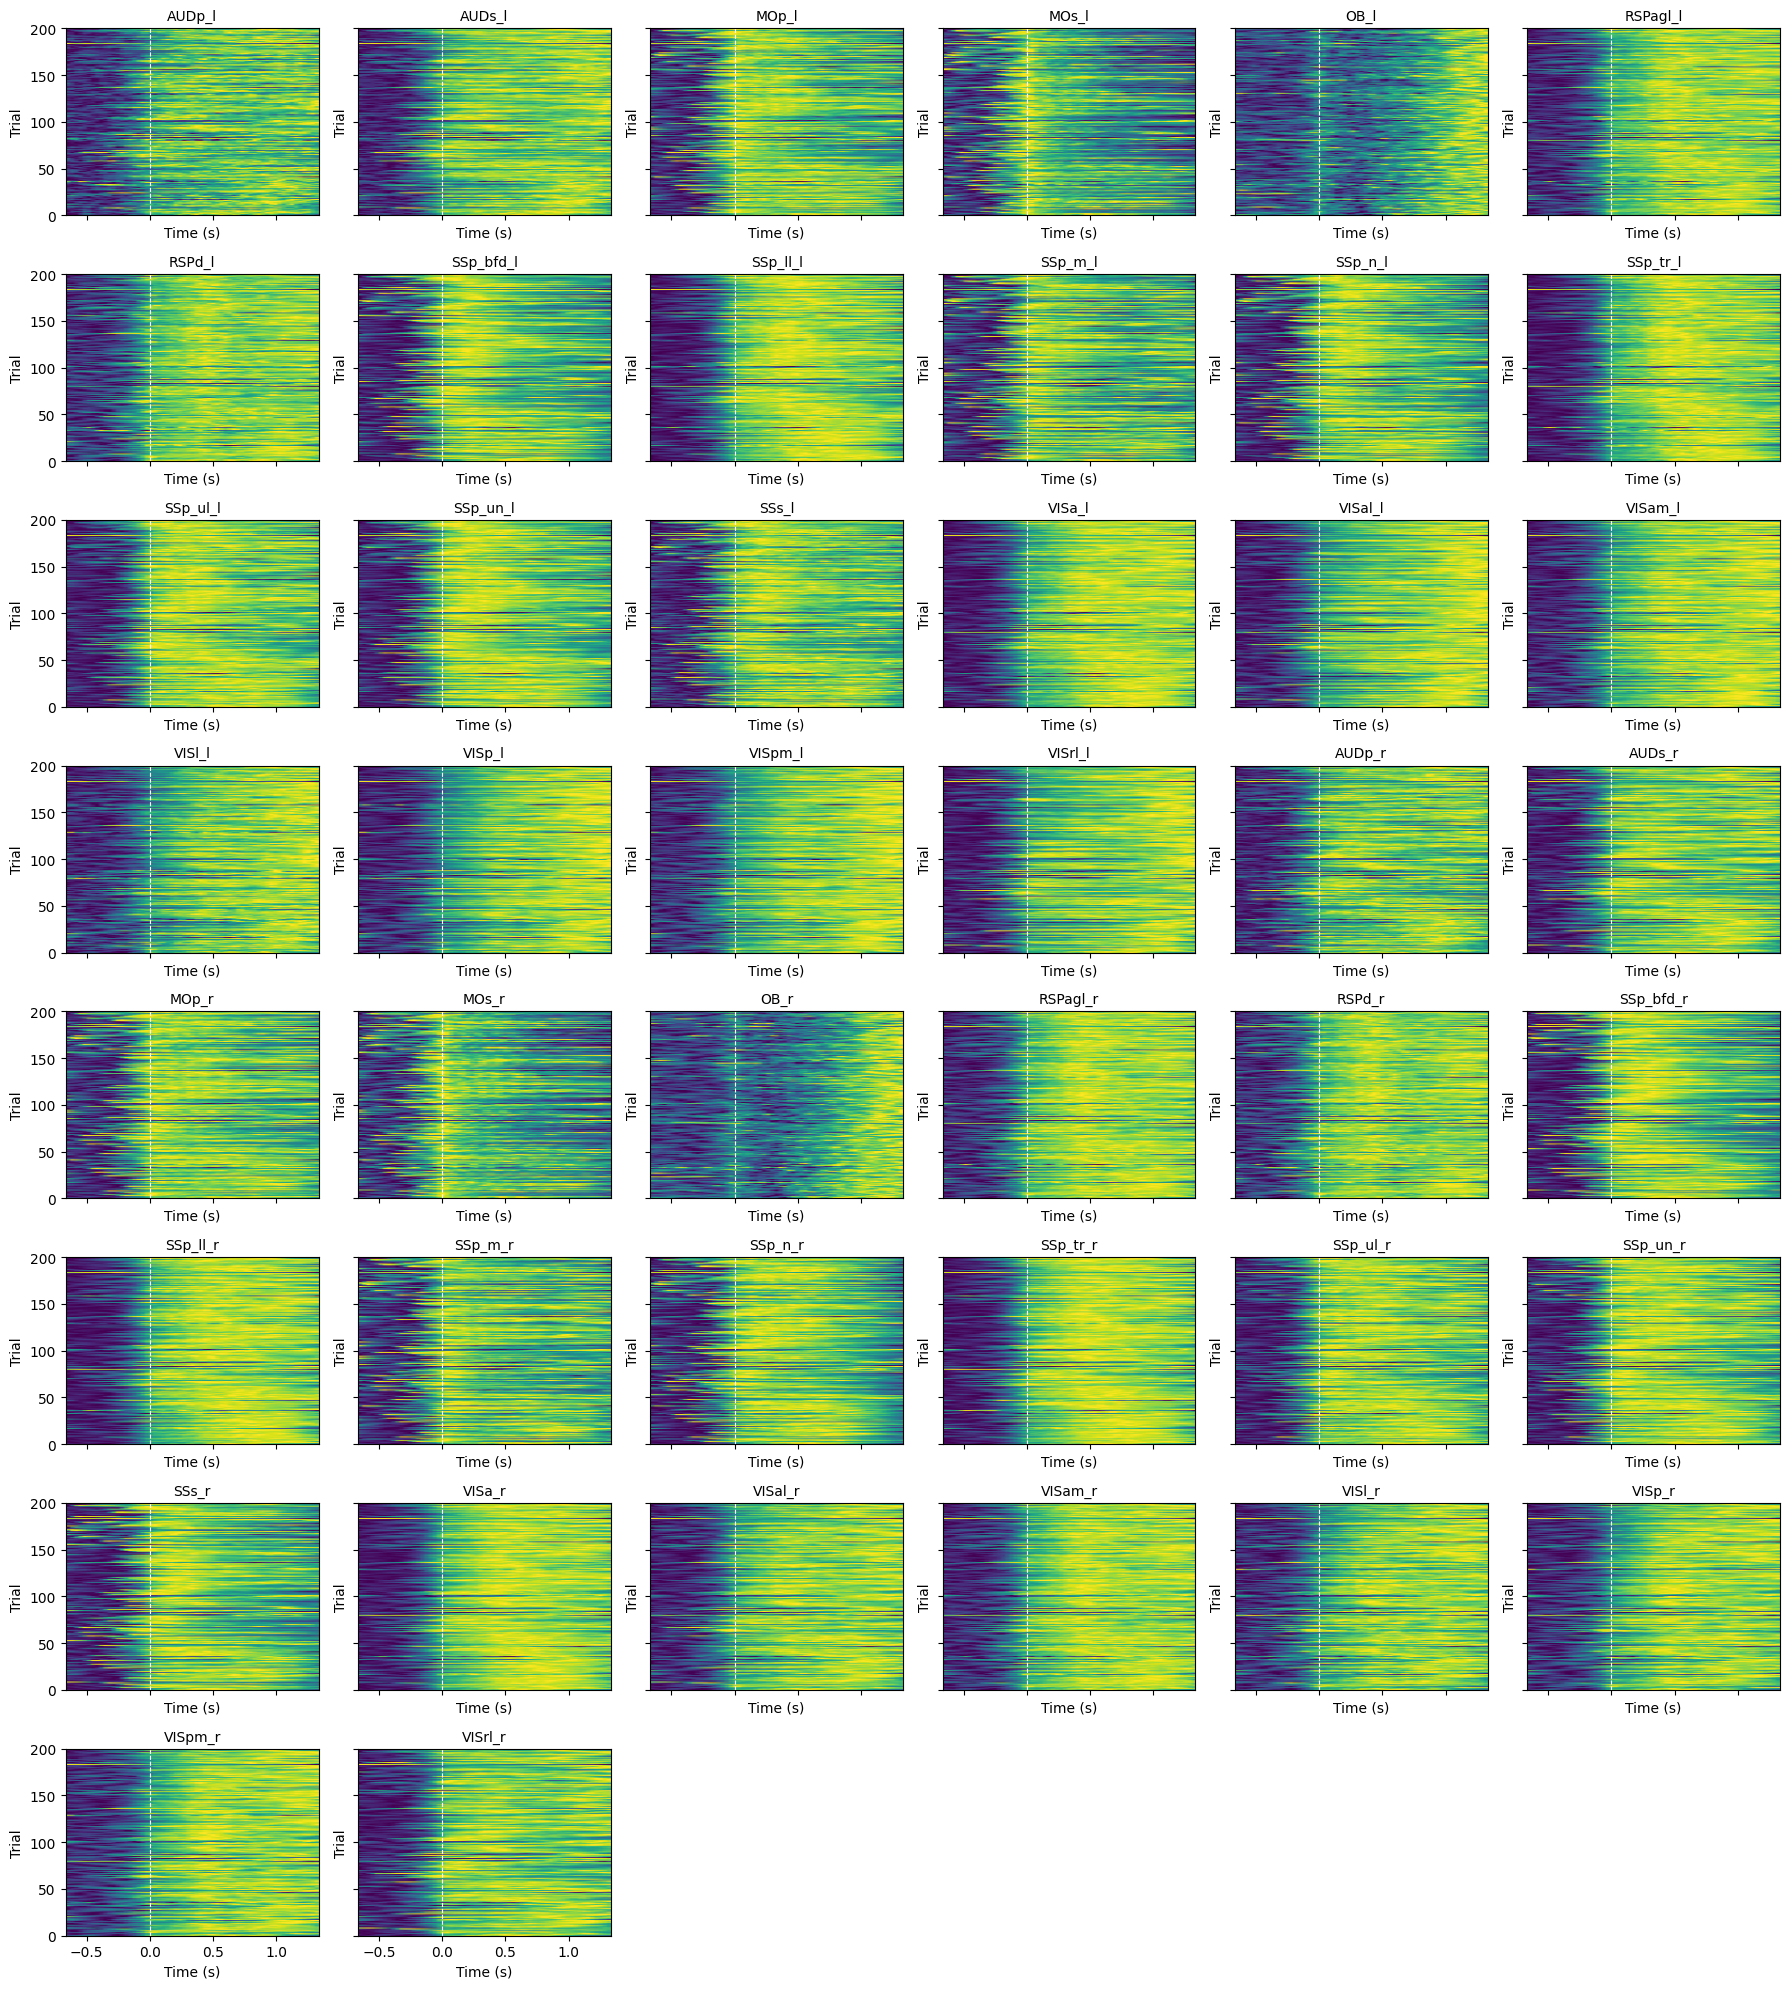

In [ ]:
#正規化して見やすくした（コード未確認
import numpy as np
import matplotlib.pyplot as plt
from math import ceil

# --- ヒートマップ描画用関数 ---
def plot_roi_heatmaps(roi_trials_dict, time_axis, title_prefix=""):
    n_rois = len(roi_trials_dict)
    n_cols = 6
    n_rows = ceil(n_rois / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*3, n_rows*2.5), sharex=True, sharey=True)
    axes = axes.flatten()

    for ax, (roi, trials) in zip(axes, roi_trials_dict.items()):
        if len(trials) == 0:
            ax.axis('off')
            continue
        data = np.stack(trials)  # shape: (n_trials, n_timepoints)
        normalized_data = (data.T - data.min(axis=1)) / (data.max(axis=1) - data.min(axis=1) + 1e-8)
        data = normalized_data.T
        im = ax.imshow(data, aspect='auto', cmap='viridis',
                       extent=[time_axis[0], time_axis[-1], 0, data.shape[0]],
                       origin='lower')
        ax.axvline(0, color='white', linestyle='--', linewidth=0.8)
        ax.set_title(f"{title_prefix}{roi}", fontsize=10)
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Trial')

    for ax in axes[n_rois:]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# --- 試行抽出（音なしレバー引きすべて） ---
roi_trials_all = extract_roi_trials(filtered_trials)

# --- ヒートマップ描画 ---
plot_roi_heatmaps(roi_trials_all, time_axis)


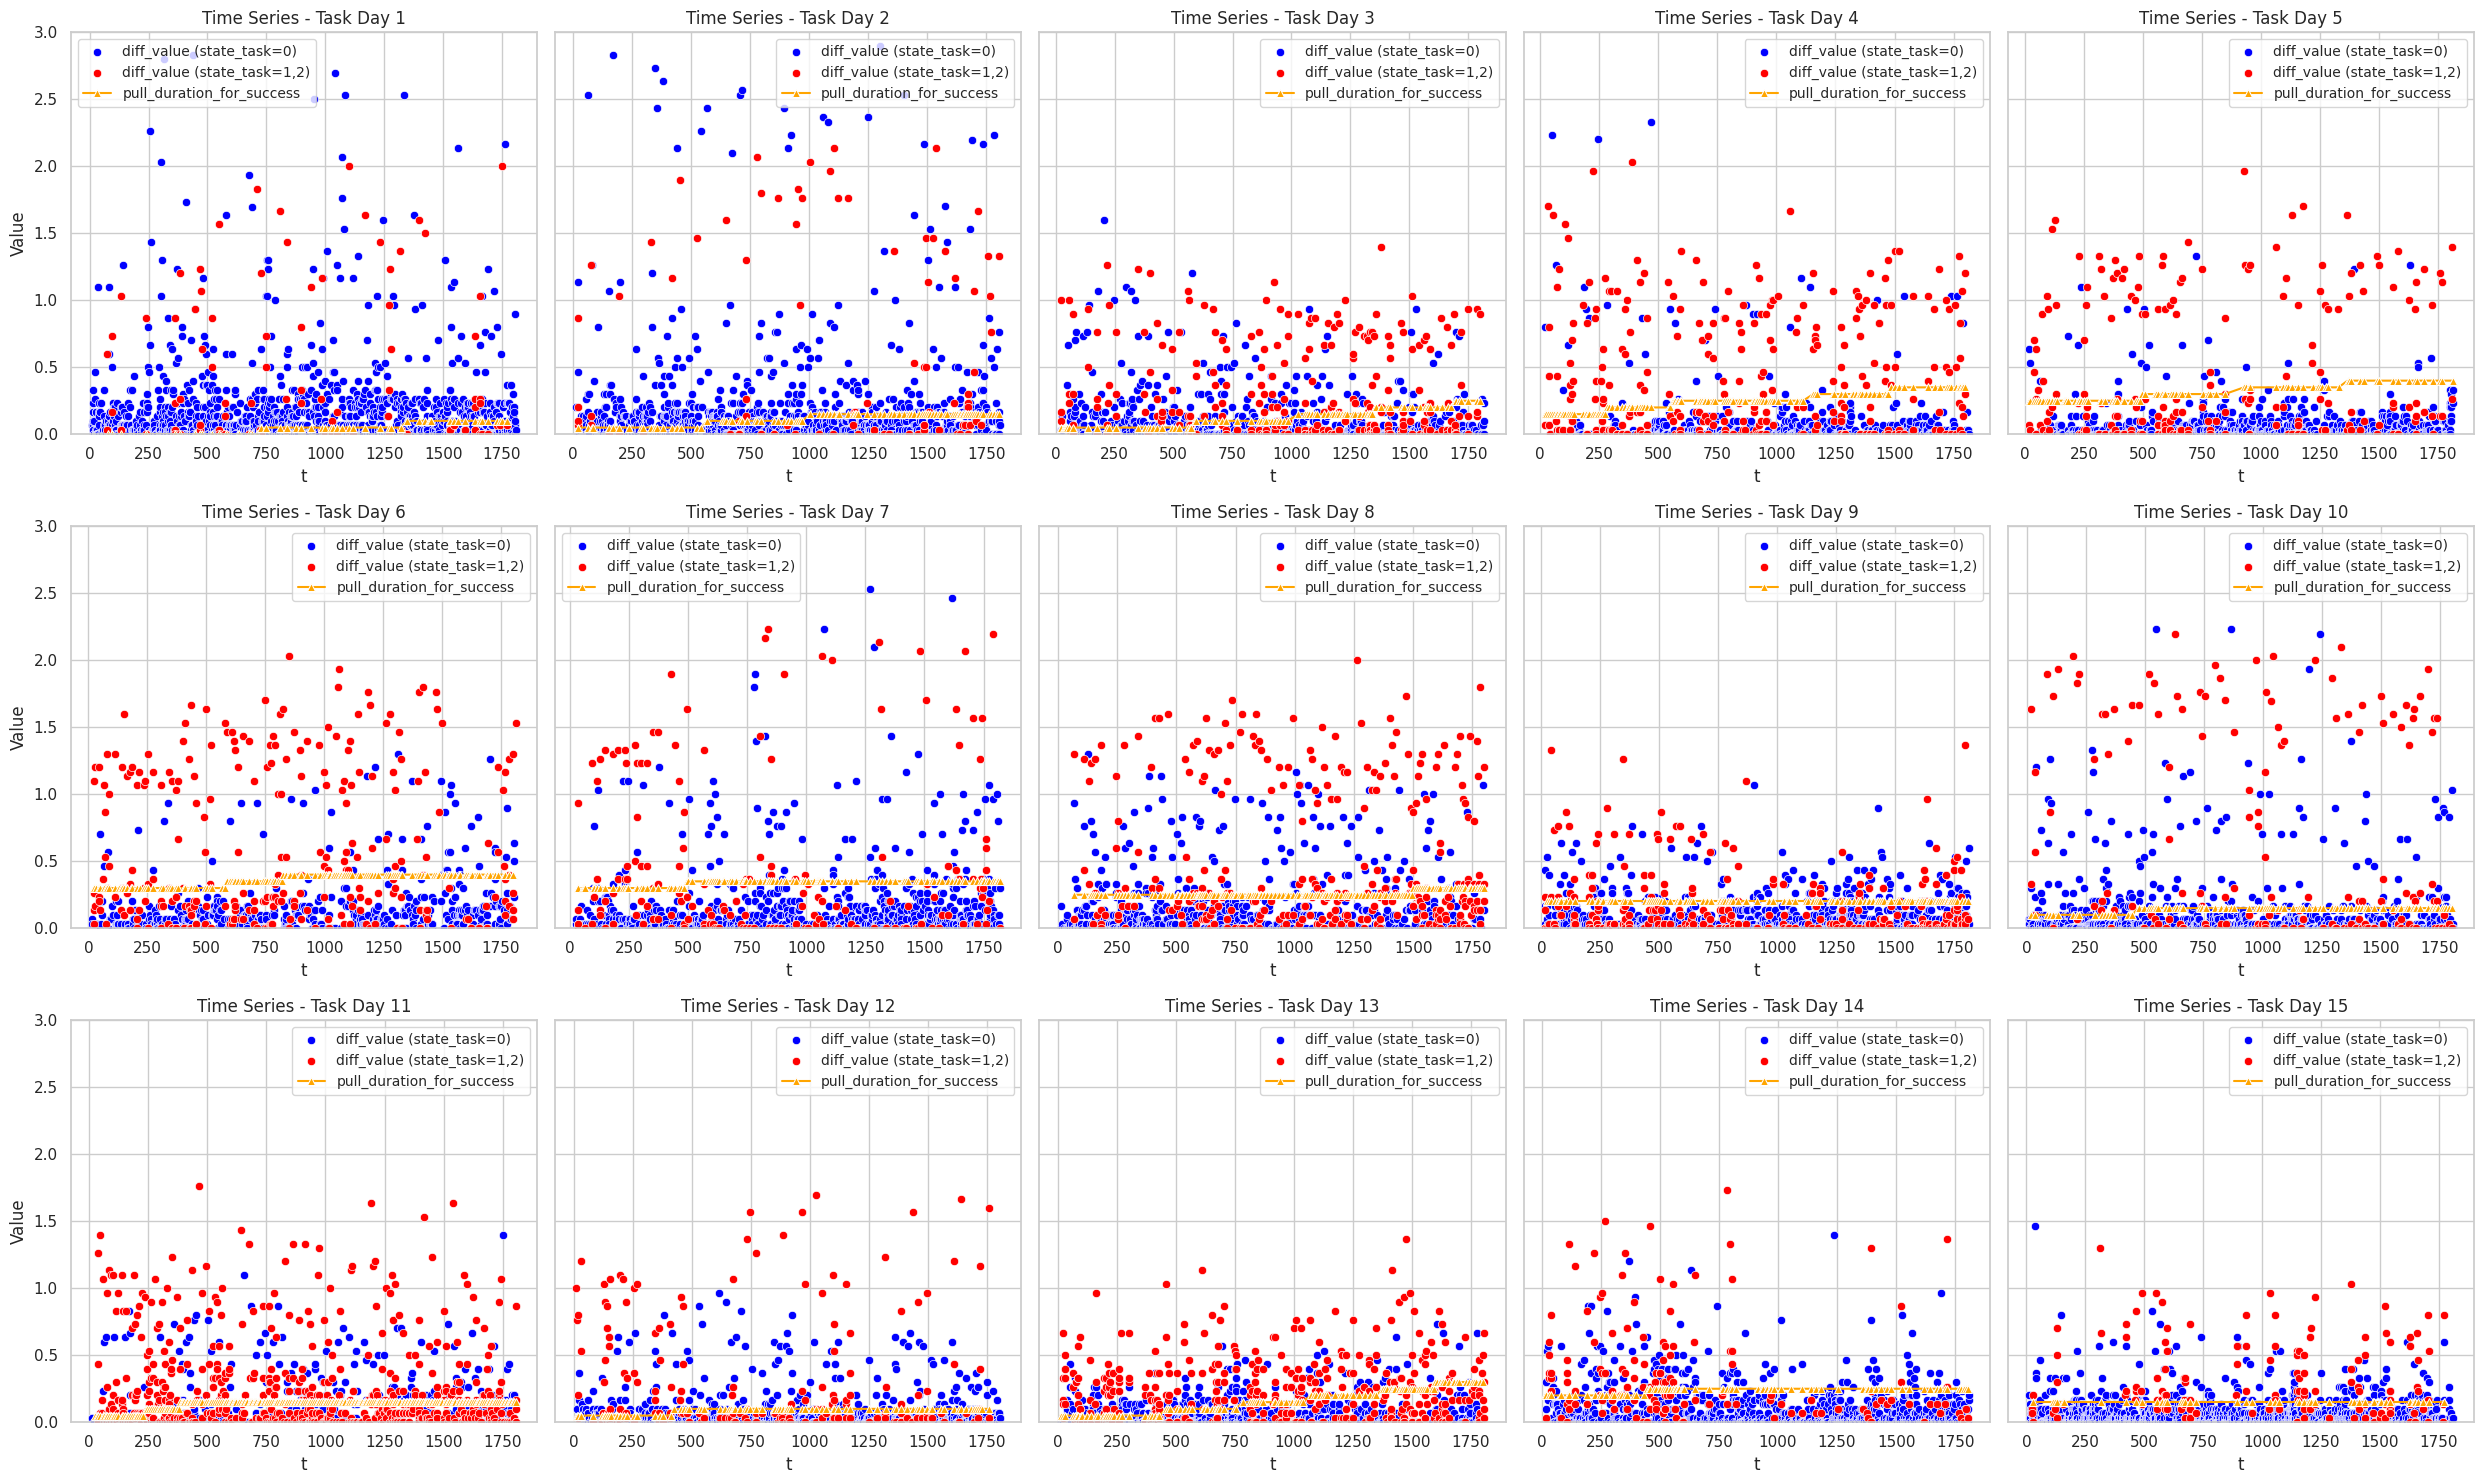

In [ ]:
#diff_valueの下限なし

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# 閾値の設定
threshold_lower = 0.04
threshold_upper = 3.0


y_min, y_max = 0, 3

# 3行×5列のサブプロット作成（sharey=Trueで縦軸を揃える）
fig, axes = plt.subplots(3, 5, figsize=(25, 15), sharey=True)
axes = axes.flatten()

for day in range(1, 16):
    ax = axes[day-1]
    file_path = f'/content/drive/MyDrive/hackathon_data/VG1GC-61/task-day{day}/trials_L1L2.csv'

    # ファイルが存在しなければサブプロットにメッセージを表示
    if not os.path.exists(file_path):
        ax.text(0.5, 0.5, f"File not found:\nTask Day {day}", ha='center', va='center')
        ax.set_title(f"Task Day {day}")
        ax.set_xlabel("t")
        ax.set_ylabel("Value")
        continue

    df = pd.read_csv(file_path)

    if 't' in df.columns:
        # diff_value: 閾値内 (0.04 < diff_value < 3.0) のデータを抽出
        df_diff = df[ (df['diff_value'] < threshold_upper)]

        # state_task==0 のデータ
        df_state0 = df_diff[df_diff['state_task'] == 0]
        # state_task==1,2 のデータ
        df_state12 = df_diff[df_diff['state_task'].isin([1, 2])]

        # state_task==0 は青色の散布図
        sns.scatterplot(x='t', y='diff_value', data=df_state0, marker='o',
                        label='diff_value (state_task=0)', color='blue', ax=ax)
        # state_task==1,2 は赤色の散布図
        sns.scatterplot(x='t', y='diff_value', data=df_state12, marker='o',
                        label='diff_value (state_task=1,2)', color='red', ax=ax)

        # pull_duration_for_successが存在する場合は緑色の線グラフ
        if 'pull_duration_for_success' in df.columns:
            sns.lineplot(x='t', y='pull_duration_for_success', data=df, marker='^',
                         label='pull_duration_for_success',color='orange' , ax=ax)

        ax.set_xlabel("t")
        ax.set_ylabel("Value")
        ax.set_title(f"Time Series - Task Day {day}")
        ax.set_ylim(y_min, y_max)
        # サブプロット毎の凡例が重なる場合は、表示位置を調整することも可能です
        ax.legend(fontsize='small')
    else:
        ax.text(0.5, 0.5, "No 't' column", ha='center', va='center')
        ax.set_title(f"Task Day {day}")

plt.tight_layout()
plt.show()


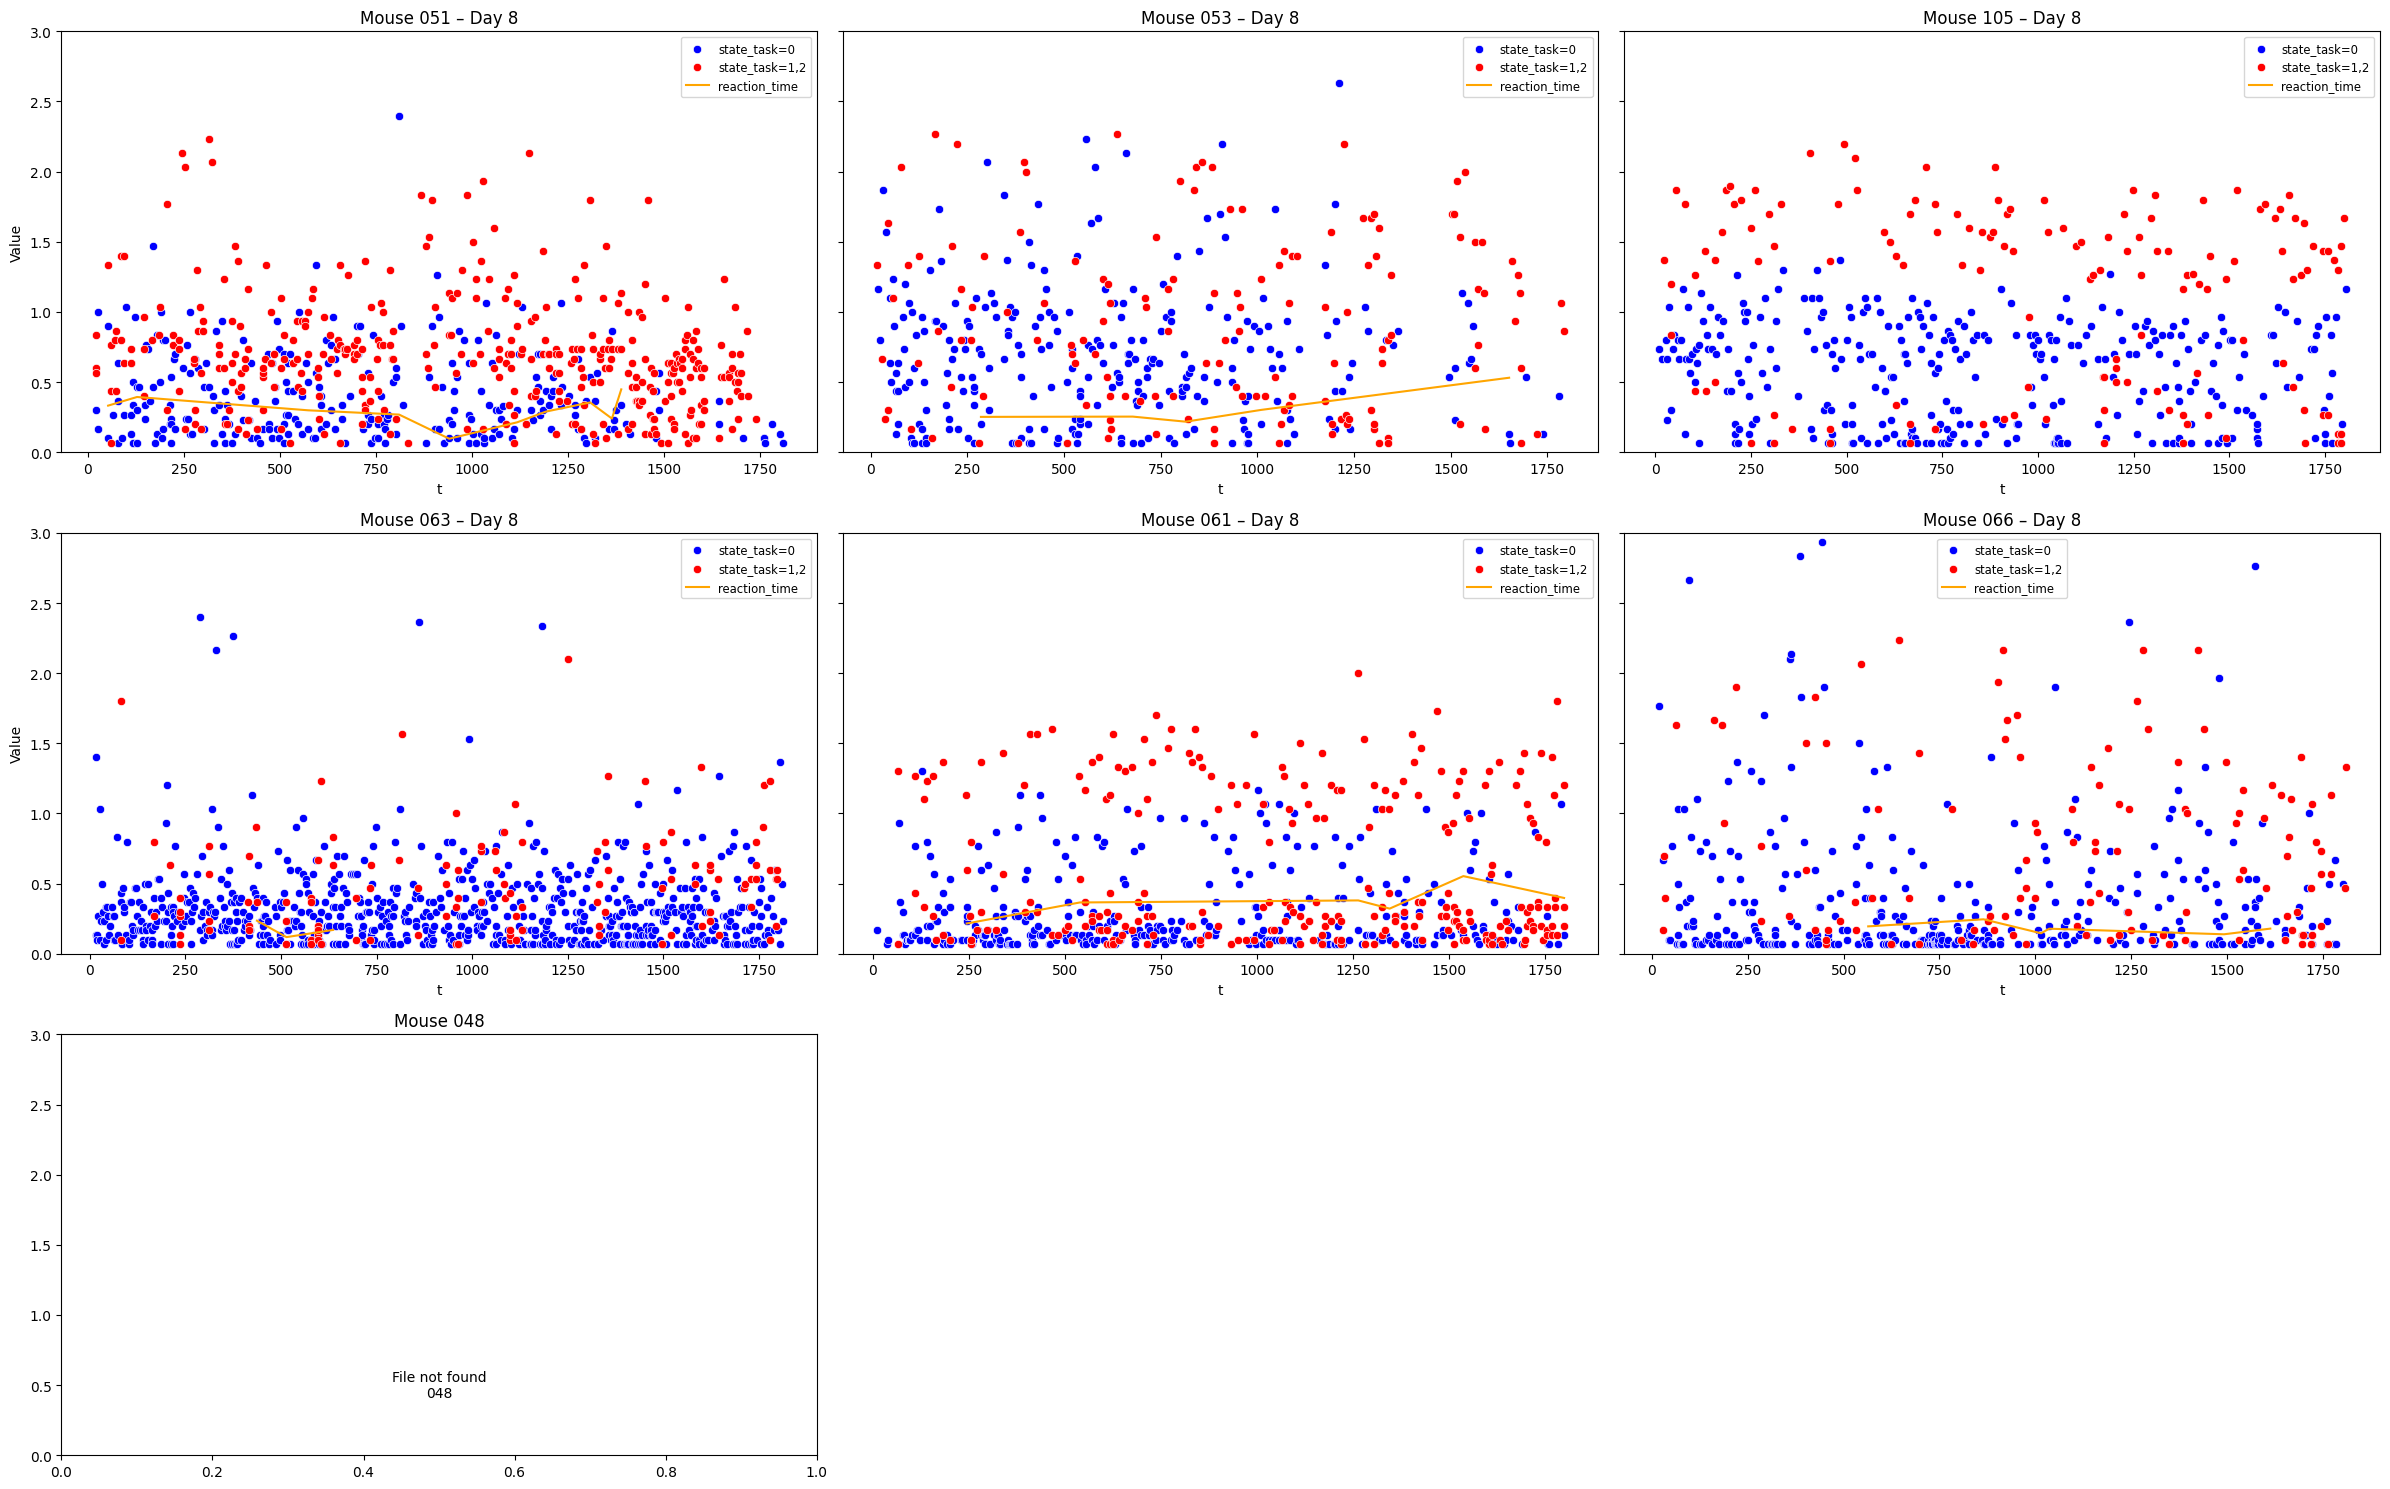

In [ ]:
#クラスタAのDAY８のレバー引き時間を可視化。pull?durationも消えてるし、reaction_timeの点もなくなっている

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, math

# 対象個体とパスのひな形
subjects = ["051", "053", "105", "063", "061", "066", "048"]
path_tpl  = "/content/drive/MyDrive/hackathon_data/VG1GC-{}/task-day8/trials_L1L2.csv"

# プロット設定
th_low, th_high = 0.04, 3.0       # diff_value の範囲
y_min, y_max    = 0, 3            # y 軸共通スケール
n_cols          = 3               # 列数（好みで変更可）
n_rows          = math.ceil(len(subjects) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols,
                         figsize=(8 * n_cols, 5 * n_rows),
                         sharey=True)
axes = axes.flatten()

for i, sid in enumerate(subjects):
    ax = axes[i]

    # 先頭ゼロあり／なしの両方を試す
    candidate_paths = [
        path_tpl.format(sid.lstrip("0")),   # 例: 051 → 51
        path_tpl.format(sid)                # 例: 051
    ]
    file_path = next((p for p in candidate_paths if os.path.exists(p)), None)

    if file_path is None:
        ax.text(0.5, 0.5, f"File not found\n{sid}", ha="center", va="center")
        ax.set_title(f"Mouse {sid}")
        continue

    df = pd.read_csv(file_path)

    # 条件フィルタ
    mask = (df["diff_value"] > th_low) & (df["diff_value"] < th_high)
    df = df[mask]

    # state_task 別に描画
    df0  = df[df["state_task"] == 0]
    df12 = df[df["state_task"].isin([1, 2])]

    sns.scatterplot(data=df0,  x="t", y="diff_value",
                    color="blue",  label="state_task=0",  ax=ax)
    sns.scatterplot(data=df12, x="t", y="diff_value",
                    color="red",   label="state_task=1,2", ax=ax)

    # reaction_time がある場合
    if "reaction_time" in df.columns:
        sns.lineplot(data=df, x="t", y="reaction_time",
                     color="orange", label="reaction_time", ax=ax)

    ax.set_title(f"Mouse {sid} – Day 8")
    ax.set_xlabel("t")
    ax.set_ylabel("Value")
    ax.set_ylim(y_min, y_max)
    ax.legend(fontsize="small")

# 余った sub-axes を消す（7匹→9枠中2枠空き）
for j in range(len(subjects), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()
